In [3]:
!pip install imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [4]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.8 MB/s eta 0:00:0000:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitli

In [11]:
import pandas as pd
import numpy as np
import glob
import os
import time
import joblib
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn Imports (Core) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif as sklearn_f_classif
from sklearn.ensemble import RandomForestClassifier # Main model

# --- imbalanced-learn imports ---
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    imblearn_available = True
    print("Checkpoint A: imbalanced-learn imported successfully.")
except ImportError as e:
    imblearn_available = False
    print(f"Failed to import imblearn: {e}. Resampling may not be available.")
    SMOTE, RandomUnderSampler, ImbPipeline = None, None, None

# --- CTGAN Import ---
try:
    from ctgan import CTGAN
    ctgan_available = True
    print("CTGAN library imported successfully.")
except ImportError:
    ctgan_available = False
    CTGAN = None
    print("WARNING: CTGAN library not found. Web attack augmentation with CTGAN will be skipped.")

# --- LightGBM Import (for Web Attack Detector) ---
try:
    from lightgbm import LGBMClassifier
    lgbm_available = True # To track if LGBM can be used
    print("Checkpoint D: LightGBM imported successfully.")
except ImportError:
    LGBMClassifier = None
    lgbm_available = False
    print("Warning: LightGBM not found. Web attack detector may use a fallback or not be trained.")

# --- SHAP Import ---
try:
    import shap
    shap_available = True
    print("SHAP library imported successfully.")
except ImportError:
    shap_available = False
    shap = None
    print("WARNING: SHAP library not found. Advanced explainability will be limited.")

print("Checkpoint B: Proceeding with CPU-only execution.")
print("Scikit-learn RandomForestClassifier for main model. LGBM (if available) for web detector.")
print("Checkpoint C: CPU-only mode confirmed.")

# --- Configuration ---
DATA_PATH = "/kaggle/input/network-intrusion-detection/BCCC-CIC-IDS2017/BCCC-CIC-IDS-2017/"
OUTPUT_PATH = "/kaggle/working/"
SAMPLE_FRACTION = 1.0 # For faster testing, set to e.g., 0.1
RANDOM_STATE = 42

PERFORM_FEATURE_SELECTION = True
N_FEATURES_TO_SELECT = 60 # Target number of features after selection
WEB_ATTACK_CLASSES = ['Web_Brute_Force', 'Web_SQL_Injection', 'Web_XSS'] # Must match exact label names
RESAMPLING_METHOD_MAIN = 'SMOTE_RUS' # For the main RandomForest model
WEB_ATTACK_REFINEMENT_THRESHOLD = 0.7

# CTGAN Config
USE_CTGAN_FOR_WEB_AUGMENTATION = True
CTGAN_EPOCHS = 20 # Reduced for speed
CTGAN_BATCH_SIZE = 250 # Smaller batch for potentially small web attack class data
CTGAN_SAMPLES_PER_MINORITY_CLASS_TARGET = 300 # Target total samples (real + synthetic)
MIN_REAL_SAMPLES_FOR_CTGAN = 15 # Minimum real samples to attempt CTGAN

print(f"Checkpoint F: Config set. DATA_PATH='{DATA_PATH}', FS='{PERFORM_FEATURE_SELECTION}', N_FEAT_SELECT='{N_FEATURES_TO_SELECT}', RESAMPLE_MAIN='{RESAMPLING_METHOD_MAIN}'")
print(f"Web Attack Augmentation: CTGAN={USE_CTGAN_FOR_WEB_AUGMENTATION}, Epochs={CTGAN_EPOCHS if USE_CTGAN_FOR_WEB_AUGMENTATION else 'N/A'}")

# NFStream Compatible Features (Ensure these names are robust)
NFSTREAM_COMPATIBLE_FEATURES = [
    'duration', 'packets_count', 'fwd_packets_count', 'bwd_packets_count',
    'total_payload_bytes', 'fwd_total_payload_bytes', 'bwd_total_payload_bytes',
    'payload_bytes_max', 'payload_bytes_min', 'payload_bytes_mean', 'payload_bytes_std', 'payload_bytes_variance',
    'fwd_payload_bytes_max', 'fwd_payload_bytes_min', 'fwd_payload_bytes_mean', 'fwd_payload_bytes_std', 'fwd_payload_bytes_variance',
    'bwd_payload_bytes_max', 'bwd_payload_bytes_min', 'bwd_payload_bytes_mean', 'bwd_payload_bytes_std', 'bwd_payload_bytes_variance',
    'total_header_bytes', 'max_header_bytes', 'min_header_bytes', 'mean_header_bytes', 'std_header_bytes',
    'fwd_total_header_bytes', 'fwd_max_header_bytes', 'fwd_min_header_bytes', 'fwd_mean_header_bytes', 'fwd_std_header_bytes',
    'bwd_total_header_bytes', 'bwd_max_header_bytes', 'bwd_min_header_bytes', 'bwd_mean_header_bytes', 'bwd_std_header_bytes',
    'fwd_avg_segment_size', 'bwd_avg_segment_size', 'avg_segment_size',
    'fwd_init_win_bytes', 'bwd_init_win_bytes',
    'bytes_rate', 'packets_rate', 'fwd_bytes_rate', 'bwd_bytes_rate',
    'fwd_packets_rate', 'bwd_packets_rate', 'down_up_rate',
    'fin_flag_counts', 'psh_flag_counts', 'urg_flag_counts', 'ece_flag_counts',
    'syn_flag_counts', 'ack_flag_counts', 'cwr_flag_counts', 'rst_flag_counts',
    'fwd_fin_flag_counts', 'fwd_psh_flag_counts', 'fwd_urg_flag_counts', 'fwd_ece_flag_counts',
    'fwd_syn_flag_counts', 'fwd_ack_flag_counts', 'fwd_cwr_flag_counts', 'fwd_rst_flag_counts',
    'bwd_fin_flag_counts', 'bwd_psh_flag_counts', 'bwd_urg_flag_counts', 'bwd_ece_flag_counts',
    'bwd_syn_flag_counts', 'bwd_ack_flag_counts', 'bwd_cwr_flag_counts', 'bwd_rst_flag_counts',
    'packets_IAT_mean', 'packet_IAT_std', 'packet_IAT_max', 'packet_IAT_min', 'packet_IAT_total',
    'fwd_packets_IAT_mean', 'fwd_packets_IAT_std', 'fwd_packets_IAT_max', 'fwd_packets_IAT_min', 'fwd_packets_IAT_total',
    'bwd_packets_IAT_mean', 'bwd_packets_IAT_std', 'bwd_packets_IAT_max', 'bwd_packets_IAT_min', 'bwd_packets_IAT_total'
]
# Sanitize NFSTREAM_COMPATIBLE_FEATURES list immediately
NFSTREAM_COMPATIBLE_FEATURES = [f.strip().replace(' ', '_').replace('/', '_').replace('-', '_') for f in NFSTREAM_COMPATIBLE_FEATURES]

# --- Helper Functions (Plotting - from your original script, slightly adapted) ---
def plot_feature_importance(model, feature_names, top_n=30, save_path=None, model_name="Model"):
    if not hasattr(model, 'feature_importances_'): print(f"{model_name} no feature_importances_"); return
    importances = np.array(model.feature_importances_) # Ensure numpy array
    if isinstance(feature_names, (pd.Index, pd.Series)): feature_names = feature_names.tolist()
    f_names_safe = np.array(feature_names) if feature_names and len(feature_names) == len(importances) else np.array([f"Feat_{i}" for i in range(len(importances))])
    indices = np.argsort(importances)[::-1]; plot_n = min(top_n, len(f_names_safe))
    if plot_n == 0: print(f"No features for {model_name} importance plot."); return
    plt.figure(figsize=(12, max(8, plot_n * 0.35))); plt.title(f'Top {plot_n} Feature Importances ({model_name})')
    plt.barh(range(plot_n), importances[indices][:plot_n], align='center'); plt.yticks(range(plot_n), f_names_safe[indices][:plot_n])
    plt.gca().invert_yaxis(); plt.xlabel('Relative Importance'); plt.tight_layout()
    if save_path: os.makedirs(os.path.dirname(save_path), exist_ok=True); plt.savefig(save_path, bbox_inches='tight'); print(f"Plot saved: {save_path}")
    plt.show(); plt.close()

def plot_confusion_matrix(cm_df, title='Confusion Matrix', save_path=None):
    plt.figure(figsize=(min(20, len(cm_df.columns)*0.9), min(18, len(cm_df.index)*0.8))) # Adjusted size
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis', cbar=True, annot_kws={"size": 7}) # viridis, smaller font
    plt.title(title, fontsize=15); plt.ylabel('True Label', fontsize=12); plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=50, ha='right', fontsize=8); plt.yticks(rotation=0, fontsize=8); plt.tight_layout()
    if save_path: os.makedirs(os.path.dirname(save_path), exist_ok=True); plt.savefig(save_path, bbox_inches='tight'); print(f"Plot saved: {save_path}")
    plt.show(); plt.close()
print("Checkpoint G: Helper functions defined.")

# --- Load and Combine Data (Adapted from your script) ---
def load_and_combine_data_nf(path_to_csv_folder):
    csv_files = glob.glob(os.path.join(path_to_csv_folder, "*.csv"))
    if not csv_files: raise FileNotFoundError(f"No CSVs in {path_to_csv_folder}.")
    df_list = []
    print(f"Found {len(csv_files)} CSVs.")
    for file in csv_files:
        try:
            df_temp = pd.read_csv(file, low_memory=False)
            df_temp.columns = [col.strip().replace(' ', '_').replace('/', '_').replace('-', '_') for col in df_temp.columns]
            label_col_present = 'label' if 'label' in df_temp.columns else ('Label' if 'Label' in df_temp.columns else None)
            if not label_col_present: continue
            if label_col_present != 'label': df_temp.rename(columns={label_col_present: 'label'}, inplace=True)
            df_list.append(df_temp)
        except Exception: pass # Simplified for brevity
    if not df_list: raise ValueError("No dataframes loaded.")
    full_df = pd.concat(df_list, ignore_index=True)
    if 'label' not in full_df.columns: raise ValueError("Final DF missing 'label'.")
    print(f"Combined dataset shape (NF focus): {full_df.shape}")
    return full_df

# --- Preprocessing with NFStream Focus (Adapted) ---
def preprocess_data_nfstream_focus(df_original):
    print("Preprocessing for NFStream features...")
    df = df_original.copy() # Columns assumed sanitized by loader
    label_col = 'label'
    if label_col not in df.columns: raise ValueError(f"'{label_col}' not found.")
    
    features_to_use = [f for f in NFSTREAM_COMPATIBLE_FEATURES if f in df.columns and f != label_col]
    if not features_to_use: raise ValueError("No NFStream compatible features after filtering.")

    X = df[features_to_use].copy()
    y_series = df[label_col].astype(str)
    X = X.replace([np.inf, -np.inf], np.nan)
    for col in X.columns:
        if X[col].dtype == 'object': X[col] = pd.to_numeric(X[col], errors='coerce')
    X.fillna(0.0, inplace=True)

    valid_idx = y_series.notna() # X should be fine after fillna
    X, y_series = X[valid_idx], y_series[valid_idx]
    if X.empty: raise ValueError("X empty after preprocessing.")

    le = LabelEncoder(); y_encoded = le.fit_transform(y_series)
    print(f"LabelEncoder classes ({len(le.classes_)}): {le.classes_.tolist()[:5]}...")

    web_attack_labels_present = [cls for cls in le.classes_ if cls in WEB_ATTACK_CLASSES] # Renamed
    is_web_attack_binary = y_series.apply(lambda x: 1 if x in web_attack_labels_present else 0) # Renamed
    
    if X.isnull().values.any() or np.isinf(X.values).any(): # Should be redundant
         X = pd.DataFrame(np.nan_to_num(X.values, nan=0.0, posinf=0.0, neginf=0.0), columns=X.columns, index=X.index)
    return X, y_encoded, le, is_web_attack_binary

# --- Feature Selection (Adapted from your script) ---
def perform_feature_selection_nf(X_df, y_np, n_features_target=60, random_state_val=42): # Renamed
    print(f"Performing FS from {X_df.shape[1]} to target ~{n_features_target} features...")
    orig_feature_names = np.array(X_df.columns) # Renamed
    if X_df.empty or len(y_np)==0 or X_df.shape[0]!=len(y_np): return orig_feature_names.tolist()
    X_clean_np = np.nan_to_num(X_df.values, nan=0.0, posinf=0.0, neginf=0.0) # More robust inf handling

    k_actual_fs = min(n_features_target, X_clean_np.shape[1]) # Renamed
    selected_kbest = []; variances = np.var(X_clean_np, axis=0) # Renamed
    non_const_mask = variances > 1e-9 # Renamed
    k_skb = min(k_actual_fs, np.sum(non_const_mask))
    if k_skb > 0:
        try:
            skb_selector = SelectKBest(sklearn_f_classif, k=k_skb) # Renamed
            skb_selector.fit(X_clean_np[:, non_const_mask], y_np)
            orig_indices_non_const = np.where(non_const_mask)[0] # Renamed
            selected_kbest = orig_feature_names[orig_indices_non_const[skb_selector.get_support()]].tolist()
        except Exception as e: print(f"SelectKBest error: {e}")
    print(f"SelectKBest selected: {len(selected_kbest)}")

    selected_rf_fs = []; rf_fs_model_instance = None # Renamed
    # Using RandomForest for FS as per original script, not LGBM for this step
    try:
        rf_fs_model_instance = RandomForestClassifier(n_estimators=30, random_state=random_state_val, n_jobs=-1, max_depth=15, min_samples_leaf=10).fit(X_clean_np, y_np)
        rf_selector_sfm = SelectFromModel(rf_fs_model_instance, threshold="median", prefit=True) # Renamed
        selected_rf_fs = orig_feature_names[rf_selector_sfm.get_support()].tolist()
    except Exception as e: print(f"RF SelectFromModel error: {e}")
    print(f"RF SelectFromModel selected: {len(selected_rf_fs)}")
    
    combined_selected = list(set(selected_kbest + selected_rf_fs)) # Renamed
    min_final_feats = max(1, min(20, X_df.shape[1] // 4)) # Renamed
    if not combined_selected or len(combined_selected) < min_final_feats:
        if rf_fs_model_instance and hasattr(rf_fs_model_instance, 'feature_importances_'):
            imp_order_fs = np.argsort(rf_fs_model_instance.feature_importances_)[::-1] # Renamed
            num_return = min(k_actual_fs if k_actual_fs > 0 else min_final_feats, len(orig_feature_names)) # Renamed
            return orig_feature_names[imp_order_fs][:num_return].tolist()
        num_return_fallback = min(k_actual_fs if k_actual_fs > 0 else min_final_feats, len(orig_feature_names))
        return orig_feature_names[:num_return_fallback].tolist()

    if len(combined_selected) > k_actual_fs and k_actual_fs > 0:
        if rf_fs_model_instance and hasattr(rf_fs_model_instance, 'feature_importances_'):
            feat_to_idx = {name: i for i, name in enumerate(orig_feature_names)} # Renamed
            imp_map_fs = {feat: rf_fs_model_instance.feature_importances_[feat_to_idx[feat]] for feat in combined_selected if feat in feat_to_idx} # Renamed
            sorted_by_imp_fs = sorted(combined_selected, key=lambda x: imp_map_fs.get(x, 0), reverse=True) # Renamed
            return sorted_by_imp_fs[:k_actual_fs]
        return combined_selected[:k_actual_fs]
    return combined_selected

# --- Resampling (Adapted from your script) ---
def get_resampling_pipeline_nf(y_train_labels, method_name='SMOTE_RUS', random_state_val=42): # Renamed
    if not imblearn_available or method_name == 'NONE' or method_name is None: return None
    if len(y_train_labels) == 0: return None
    unique_cls, cls_counts = np.unique(y_train_labels, return_counts=True) # Renamed
    if len(unique_cls) <= 1: return None
    cls_dist = dict(zip(unique_cls, cls_counts)); majority_label = max(cls_dist, key=cls_dist.get); majority_n = cls_dist[majority_label] # Renamed
    if majority_n == 0: return None
    over_strat = {}; min_smote_k_samples = 6 # Renamed
    for cls_val, n_val in cls_dist.items(): # Renamed
        if cls_val == majority_label or n_val == 0: continue
        if n_val < min_smote_k_samples: target_n = n_val
        elif n_val < 2500: target_n = min(max(n_val * 1.8, int(majority_n * 0.08)), int(majority_n * 0.18))
        else: target_n = min(max(n_val, int(majority_n * 0.20)), int(majority_n * 0.35)) # Adjusted ratios
        over_strat[cls_val] = max(n_val, int(target_n))
    if not over_strat: return None
    eligible_k_counts = [cls_dist[c] for c in over_strat if c in cls_dist and cls_dist[c] >= min_smote_k_samples] # Renamed
    smote_k = 1 # Renamed
    if eligible_k_counts: smote_k = max(1, min(5, min(eligible_k_counts) - 1))
    else:
        if method_name.startswith("SMOTE"): return None # Skip if no eligible classes
    
    resample_pipe = None # Renamed
    try:
        if method_name == 'SMOTE' and SMOTE:
            resample_pipe = SMOTE(sampling_strategy=over_strat, random_state=random_state_val, k_neighbors=smote_k, n_jobs=-1)
        elif method_name == 'SMOTE_RUS' and SMOTE and RandomUnderSampler and ImbPipeline:
             smote_op = SMOTE(sampling_strategy=over_strat, random_state=random_state_val, k_neighbors=smote_k, n_jobs=-1) # Renamed
             max_minority_n = max(over_strat.values()) if over_strat else 0 # Renamed
             target_majority_n_rus = int(majority_n * 0.65) # Renamed
             target_majority_n_rus = max(target_majority_n_rus, max_minority_n)
             if max_minority_n > 0: target_majority_n_rus = min(target_majority_n_rus, int(max_minority_n * 2.8))
             rus_strat_dict = {majority_label: target_majority_n_rus} # Renamed
             rus_op = RandomUnderSampler(sampling_strategy=rus_strat_dict, random_state=random_state_val) # Renamed
             resample_pipe = ImbPipeline([('SMOTE_step', smote_op), ('RUS_step', rus_op)]) # Named steps
    except Exception as e: print(f"Error creating resampler: {e}"); resample_pipe = None
    return resample_pipe

# --- Create Specialized Web Attack Detector (with CTGAN) ---
def create_web_attack_detector_nf(
    X_train_scaled_selected_feats_df, # Scaled DF with ALREADY SELECTED features for main model
    y_train_multiclass_numeric,     # Multiclass labels for the full training set (before early stopping split)
    is_web_attack_train_binary,     # Binary web attack labels for the full training set
    web_attack_str_classes,         # List of web attack class names (strings)
    main_label_encoder,             # Fitted LabelEncoder for multiclass labels
    random_state_val=42
):
    print("\nCreating specialized web attack detector (NF features)...")
    if not lgbm_available or LGBMClassifier is None: print("LGBM unavailable for web detector."); return None
    if X_train_scaled_selected_feats_df.empty: print("Web Detector: Input X is empty."); return None

    # Data for web detector is already scaled and feature-selected
    X_web_input_df = X_train_scaled_selected_feats_df.copy()
    y_web_binary = is_web_attack_train_binary.copy() # Ensure this aligns with X_web_input_df

    web_pos_idx = np.where(y_web_binary == 1)[0]; web_neg_idx = np.where(y_web_binary == 0)[0]
    if len(web_pos_idx) == 0: print("No positive web attacks for detector."); return None
    print(f"Web detector initial: Not Web={len(web_neg_idx)}, Web={len(web_pos_idx)}")

    X_web_final_train_df = X_web_input_df; y_web_final_train = y_web_binary # Defaults
    ctgan_data_added = False

    if USE_CTGAN_FOR_WEB_AUGMENTATION and ctgan_available and CTGAN is not None:
        print("Attempting CTGAN for web attack augmentation...")
        augmented_class_dfs = []
        for web_cls_name in web_attack_str_classes:
            if web_cls_name not in main_label_encoder.classes_: continue
            web_cls_num = main_label_encoder.transform([web_cls_name])[0]
            
            # Get indices from y_train_multiclass_numeric that match this web_cls_num
            # These indices should be applicable to X_train_scaled_selected_feats_df
            # (assuming their original alignment was preserved or can be mapped)
            # This part is tricky if X_train_scaled_selected_feats_df came from a further split (like early stopping)
            # For simplicity, assume y_train_multiclass_numeric aligns with the original X_train_scaled_selected_feats_df passed in
            
            # Filter X_web_input_df (which is X_train_scaled_selected_feats_df) based on y_train_multiclass_numeric
            # This requires y_train_multiclass_numeric to be indexed same as X_web_input_df
            # This usually means y_train_multiclass_numeric should be from the same split that X_train_scaled_selected_feats_df came from
            # If X_train_scaled_selected_feats_df is post-early_stopping_split, this alignment is broken.
            # Let's assume it refers to the y of the data X_train_scaled_selected_feats_df was derived from.
            # The y_train_multiclass_numeric and is_web_attack_train_binary are for the *full training set before ES split*.
            # X_train_scaled_selected_feats_df is also for the *full training set before ES split*.

            real_data_for_cls_ctgan = X_web_input_df.loc[y_train_multiclass_numeric == web_cls_num]

            if len(real_data_for_cls_ctgan) < MIN_REAL_SAMPLES_FOR_CTGAN:
                if not real_data_for_cls_ctgan.empty: augmented_class_dfs.append(real_data_for_cls_ctgan)
                continue
            print(f"  CTGAN for {web_cls_name} (real: {len(real_data_for_cls_ctgan)})")
            try:
                ctgan_input_data = real_data_for_cls_ctgan.astype(np.float64)
                ctgan = CTGAN(epochs=CTGAN_EPOCHS, batch_size=min(CTGAN_BATCH_SIZE, len(ctgan_input_data)), verbose=False)
                ctgan.fit(ctgan_input_data, discrete_columns=[]) # Fix applied
                
                num_to_gen = max(0, CTGAN_SAMPLES_PER_MINORITY_CLASS_TARGET - len(real_data_for_cls_ctgan))
                if num_to_gen > 0:
                    synth_data = ctgan.sample(num_to_gen)
                    if not isinstance(synth_data, pd.DataFrame): synth_data = pd.DataFrame(synth_data, columns=ctgan_input_data.columns)
                    else: synth_data.columns = ctgan_input_data.columns
                    augmented_class_dfs.append(synth_data)
                augmented_class_dfs.append(real_data_for_cls_ctgan) # Add real
            except Exception as e: print(f"    Error CTGAN for {web_cls_name}: {e}"); augmented_class_dfs.append(real_data_for_cls_ctgan)

        if augmented_class_dfs:
            X_web_pos_augmented = pd.concat(augmented_class_dfs, ignore_index=True)
            y_web_pos_augmented = np.ones(len(X_web_pos_augmented), dtype=int)
            X_web_neg_samples = X_web_input_df.iloc[web_neg_idx] # Negative samples
            y_web_neg_samples = np.zeros(len(X_web_neg_samples), dtype=int)

            X_web_final_train_df = pd.concat([X_web_neg_samples, X_web_pos_augmented], ignore_index=True)
            y_web_final_train = np.concatenate([y_web_neg_samples, y_web_pos_augmented])
            ctgan_data_added = True
            print(f"  Web detector data after CTGAN: {pd.Series(y_web_final_train).value_counts().to_dict()}")
            perm = np.random.RandomState(seed=random_state_val).permutation(len(X_web_final_train_df))
            X_web_final_train_df = X_web_final_train_df.iloc[perm].reset_index(drop=True); y_web_final_train = y_web_final_train[perm]
    
    if not ctgan_data_added: # Fallback to SMOTE if CTGAN not used or failed to add data
        current_pos = np.sum(y_web_final_train == 1); current_neg = np.sum(y_web_final_train == 0)
        if imblearn_available and SMOTE and current_pos >= 6 and (current_pos / (current_neg + 1e-9) < 0.75):
            print("Resampling web detector data (SMOTE)...")
            k_smote = max(1, min(5, current_pos - 1)); target_smote = current_neg
            smote_s = {0: current_neg, 1: target_smote}
            try:
                smoter = SMOTE(sampling_strategy=smote_s, random_state=random_state_val, k_neighbors=k_smote, n_jobs=-1)
                if isinstance(X_web_final_train_df, pd.DataFrame): # Should be
                    X_np_sm, y_sm = smoter.fit_resample(X_web_final_train_df.values, y_web_final_train)
                    X_web_final_train_df = pd.DataFrame(X_np_sm, columns=X_web_final_train_df.columns)
                    y_web_final_train = y_sm
                    print(f"  Web detector data resampled (SMOTE): {pd.Series(y_web_final_train).value_counts().to_dict()}")
            except Exception as e: print(f"  SMOTE for web detector error: {e}")

    web_lgbm_model = LGBMClassifier(random_state=random_state_val, n_estimators=150, learning_rate=0.05, n_jobs=-1, objective='binary', metric='binary_logloss', verbose=-1)
    print(f"Training LGBM web detector on final shape: {X_web_final_train_df.shape}")
    try:
        web_lgbm_model.fit(X_web_final_train_df, y_web_final_train)
        print("Web attack detector (LGBM) training complete.")
    except Exception as e: print(f"LGBM Web Detector Training error: {e}"); web_lgbm_model = None
    return web_lgbm_model


# --- Train Main Threat Detector (RandomForest as per original, but on NFStream features) ---
# --- Train Main Threat Detector (RandomForest as per original, but on NFStream features) ---
# --- Train Main Threat Detector (RandomForest on NFStream features) ---
def train_threat_detector_nf(
    X_train_pd_selected_feats, # DataFrame with already selected NFStream features (unscaled)
    y_train_multiclass,
    X_test_pd_selected_feats,  # DataFrame with already selected NFStream features (unscaled)
    y_test_multiclass,
    main_le,
    # ***** CORRECTED PARAMETER NAMES HERE *****
    is_web_attack_train_binary_nf_series, # Expecting a Series
    is_web_attack_test_binary_nf_series,  # Expecting a Series
    # ****************************************
    random_state_val=42,
    resampling_method_name='SMOTE_RUS'
):
    print("\nTraining Main Threat Detector (RandomForest on NFStream features)...")
    
    from sklearn.pipeline import Pipeline # Local import for clarity or ensure it's global

    main_model_scaler = Pipeline([ 
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=False)),
        ('standardscaler', StandardScaler())
    ])

    print(f"Scaling {X_train_pd_selected_feats.shape[1]} selected features for main model...")
    X_train_clean_selected = X_train_pd_selected_feats.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X_test_clean_selected = X_test_pd_selected_feats.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    X_train_scaled_main = main_model_scaler.fit_transform(X_train_clean_selected)
    X_test_scaled_main = main_model_scaler.transform(X_test_clean_selected)

    X_train_scaled_main_df = pd.DataFrame(X_train_scaled_main, columns=X_train_pd_selected_feats.columns, index=X_train_pd_selected_feats.index)

    X_train_final_fit, y_train_final_fit = X_train_scaled_main, y_train_multiclass
    if resampling_method_name != 'NONE' and resampling_method_name is not None:
        resampler_main = get_resampling_pipeline_nf(y_train_multiclass, method_name=resampling_method_name, random_state_val=random_state_val)
        if resampler_main:
            try:
                X_train_final_fit, y_train_final_fit = resampler_main.fit_resample(X_train_scaled_main, y_train_multiclass)
                print(f"Main model resampling complete. New shape: {X_train_final_fit.shape}, Y shape: {y_train_final_fit.shape}")
                print(f"Resampled class distribution: {dict(sorted(zip(np.unique(y_train_final_fit), np.bincount(y_train_final_fit))))}")
            except Exception as e: print(f"Error main model resampling: {e}.")
    
    web_detector_model = None
    if lgbm_available and is_web_attack_train_binary_nf_series is not None: # Check if Series is not None
        web_detector_model = create_web_attack_detector_nf(
            X_train_scaled_main_df, 
            y_train_multiclass,     
            is_web_attack_train_binary_nf_series.values, # Use .values here to pass NumPy array
            WEB_ATTACK_CLASSES,
            main_le,
            random_state_val=random_state_val
        )

    print("Training final RandomForestClassifier main model...")
    rf_params = {'n_estimators': 150, 'random_state': random_state_val, 'n_jobs': -1, 
                   'class_weight': 'balanced_subsample', 'max_depth': 30, 
                   'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 'sqrt'}
    main_rf_model = RandomForestClassifier(**rf_params)
    main_rf_model.fit(X_train_final_fit, y_train_final_fit)
    print("Main RF Model training complete.")

    return main_rf_model, web_detector_model, X_test_scaled_main, main_model_scaler


# --- Evaluate Model (Adapted) ---
def evaluate_model_nf(
    main_model_instance, web_detector_instance, # Renamed
    X_test_scaled_selected, y_test_actual_multiclass, # Renamed
    is_web_attack_test_binary_series, # Renamed
    main_label_encoder_instance, # Renamed
    main_model_selected_feature_names, # Renamed
    save_plots_flag=True, output_dir="." # Renamed
):
    print("\n--- Evaluating Models (NF Focus) ---")
    y_pred_main, y_proba_main = None, None # Renamed
    try:
        y_pred_main = main_model_instance.predict(X_test_scaled_selected)
        if hasattr(main_model_instance, 'predict_proba'):
            y_proba_main = main_model_instance.predict_proba(X_test_scaled_selected)
    except Exception as e: print(f"Error main model prediction: {e}"); return None, {}

    y_final_refined = np.copy(y_pred_main) # Renamed
    if web_detector_instance and y_proba_main is not None and lgbm_available:
        print("Applying web attack refinement...")
        # X_test_scaled_selected already has the correct features for web_detector
        web_probas = web_detector_instance.predict_proba(X_test_scaled_selected)[:, 1] # Prob of being web attack
        
        web_cls_indices_in_main = [] # Renamed
        for cls_name_web in WEB_ATTACK_CLASSES: # Renamed
            try: web_cls_indices_in_main.append(main_label_encoder_instance.transform([cls_name_web])[0])
            except ValueError: pass
        
        if web_cls_indices_in_main:
            overrides = 0 # Renamed
            # Indices where web detector is confident it's a web attack
            web_detector_pos_idx = np.where(web_probas > WEB_ATTACK_REFINEMENT_THRESHOLD)[0] # Renamed
            for i in web_detector_pos_idx:
                if y_pred_main[i] not in web_cls_indices_in_main: # If main model MISSED a web attack
                    # Find which web attack class main model thought was most likely among web classes
                    main_model_web_probas = y_proba_main[i, web_cls_indices_in_main] # Renamed
                    if np.sum(main_model_web_probas) > 1e-5: # If any probability mass
                        best_web_cls_local_idx = np.argmax(main_model_web_probas) # Renamed
                        y_final_refined[i] = web_cls_indices_in_main[best_web_cls_local_idx]
                        overrides += 1
            print(f"  Web refinement modified {overrides} predictions.")

    acc = accuracy_score(y_test_actual_multiclass, y_final_refined) # Renamed
    f1_m = f1_score(y_test_actual_multiclass, y_final_refined, average='macro', zero_division=0) # Renamed
    f1_w = f1_score(y_test_actual_multiclass, y_final_refined, average='weighted', zero_division=0) # Renamed
    stats = {'accuracy': acc, 'f1_macro': f1_m, 'f1_weighted': f1_w} # Renamed
    print(f"Final Acc: {acc:.4f}, F1 Macro: {f1_m:.4f}, F1 Weighted: {f1_w:.4f}")

    target_cls_names = [str(cls) for cls in main_label_encoder_instance.classes_] # Renamed
    cls_report_labels = np.arange(len(target_cls_names)) # Renamed
    cls_report = classification_report(y_test_actual_multiclass, y_final_refined, labels=cls_report_labels, target_names=target_cls_names, zero_division=0, digits=3) # Renamed
    print("\nFinal Classification Report:"); print(cls_report); stats['classification_report'] = cls_report
    
    cm = confusion_matrix(y_test_actual_multiclass, y_final_refined, labels=cls_report_labels) # Renamed
    cm_df_plot = pd.DataFrame(cm, index=target_cls_names, columns=target_cls_names); stats['confusion_matrix_df'] = cm_df_plot # Renamed
    if save_plots_flag: plot_confusion_matrix(cm_df_plot, title="Final CM (Main Model)", save_path=os.path.join(output_dir, "final_cm_main.png"))

    if save_plots_flag and main_model_instance and main_model_selected_feature_names:
        plot_feature_importance(main_model_instance, main_model_selected_feature_names, top_n=30, save_path=os.path.join(output_dir, "main_rf_model_feat_imp.png"), model_name="Main RF")

    if web_detector_instance and is_web_attack_test_binary_series is not None and lgbm_available:
        print("\n--- Web Attack Detector Evaluation ---")
        web_preds = web_detector_instance.predict(X_test_scaled_selected) # Renamed
        web_actual_vals = is_web_attack_test_binary_series.values # Renamed
        print(f"Web Detector Acc: {accuracy_score(web_actual_vals, web_preds):.4f}")
        print(classification_report(web_actual_vals, web_preds, target_names=['Not Web', 'Web'], zero_division=0, digits=3))
        if save_plots_flag:
             cm_web_plot = pd.DataFrame(confusion_matrix(web_actual_vals, web_preds), index=['Not Web', 'Web'], columns=['Pred Not Web', 'Pred Web']) # Renamed
             plot_confusion_matrix(cm_web_plot, title="Web Attack Detector CM", save_path=os.path.join(output_dir, "web_detector_cm.png"))
    return y_final_refined, stats


# --- Confidence Tiering and SHAP (Adapted) ---
def analyze_sample_with_confidence_tiers_nf(
    main_rf_model_shap, shap_explainer_rf, X_sample_scaled_selected_df, main_le_shap, # Renamed
    high_t, med_t1, med_t2_ratio, low_max_p, output_plots_dir=None # Renamed
):
    if X_sample_scaled_selected_df.empty: print("SHAP: Input sample empty."); return
    if not hasattr(main_rf_model_shap, 'predict_proba'): print("SHAP: Model no predict_proba."); return

    y_proba_s = main_rf_model_shap.predict_proba(X_sample_scaled_selected_df)[0] # Renamed
    all_class_names = main_le_shap.classes_.tolist() # Renamed
    pred_idx = np.argmax(y_proba_s); pred_p = y_proba_s[pred_idx]; pred_name = main_le_shap.inverse_transform([pred_idx])[0] # Renamed
    tier = "Undefined"; second_name = None; second_p = None # Renamed
    sorted_p_indices = np.argsort(y_proba_s)[::-1] # Renamed

    if pred_p >= high_t: tier = "High"
    else:
        if len(sorted_p_indices) > 1:
            s_idx = sorted_p_indices[1]; s_p_val = y_proba_s[s_idx] # Renamed
            if pred_p >= med_t1 and s_p_val >= (pred_p * med_t2_ratio) and s_p_val > 0.05:
                tier = "Medium_Dual"; second_name = main_le_shap.inverse_transform([s_idx])[0]; second_p = s_p_val
            elif pred_p >= med_t1: tier = "Medium_Single"
        elif pred_p >= med_t1 : tier = "Medium_Single"
        if tier == "Undefined" or (tier == "Medium_Single" and pred_p < high_t) :
            if pred_p < low_max_p: tier = "Low"
            elif tier == "Undefined": tier = "Low"
    if tier == "Undefined": tier = "Low" if pred_p < med_t1 else "Medium_Single"

    print(f"\n--- Confidence Analysis (Sample) ---")
    print(f"Top Pred: {pred_name} (P={pred_p:.4f})");
    if second_name: print(f"Second Pred: {second_name} (P={second_p:.4f})")
    print(f"Tier: {tier}")

    if shap_available and shap and shap_explainer_rf and not X_sample_scaled_selected_df.empty:
        print("  Generating SHAP explanations...")
        try:
            shap_vals_all_cls = shap_explainer_rf.shap_values(X_sample_scaled_selected_df) # Renamed
            plot_feats = X_sample_scaled_selected_df.columns.tolist() # Renamed
            
            def gen_force_plot_shap(cls_to_explain_name, plot_suffix=""): # Renamed
                cls_idx_plot = all_class_names.index(cls_to_explain_name) # Renamed
                plt.figure();
                shap.force_plot(shap_explainer_rf.expected_value[cls_idx_plot],
                                shap_vals_all_cls[cls_idx_plot][0],
                                X_sample_scaled_selected_df.iloc[0], matplotlib=True, show=False,
                                feature_names=plot_feats)
                plt.title(f"SHAP: Why {cls_to_explain_name.replace('/', '_')}?{plot_suffix}")
                if output_plots_dir:
                    os.makedirs(output_plots_dir, exist_ok=True)
                    fn = f"shap_{tier.lower()}_{cls_to_explain_name.replace('/', '_')}{plot_suffix.replace(' ','_').replace('(','').replace(')','')}.png"
                    plt.savefig(os.path.join(output_plots_dir, fn), bbox_inches='tight')
                plt.show(); plt.close()

            if tier == "High": gen_force_plot_shap(pred_name, " (High Conf)")
            elif tier == "Medium_Dual":
                gen_force_plot_shap(pred_name, " (Med Conf - Primary)")
                if second_name: gen_force_plot_shap(second_name, " (Med Conf - Secondary)")
            elif tier == "Medium_Single": gen_force_plot_shap(pred_name, " (Med Conf - Single)")
            elif tier == "Low": gen_force_plot_shap(pred_name, " (Low Conf - Weak Cand.)")
        except Exception as e: print(f"  SHAP error: {e}")
    print("--- End Sample Analysis ---")



Checkpoint A: imbalanced-learn imported successfully.
CTGAN library imported successfully.
Checkpoint D: LightGBM imported successfully.
SHAP library imported successfully.
Checkpoint B: Proceeding with CPU-only execution.
Scikit-learn RandomForestClassifier for main model. LGBM (if available) for web detector.
Checkpoint C: CPU-only mode confirmed.
Checkpoint F: Config set. DATA_PATH='/kaggle/input/network-intrusion-detection/BCCC-CIC-IDS2017/BCCC-CIC-IDS-2017/', FS='True', N_FEAT_SELECT='60', RESAMPLE_MAIN='SMOTE_RUS'
Web Attack Augmentation: CTGAN=True, Epochs=20
Checkpoint G: Helper functions defined.


In [3]:
# <CELL>
# Cell: Initial Setup and Global Variable Initialization
print(f"Checkpoint 0: Script start. Python version: {sys.version}")
warnings.filterwarnings("ignore")

# Globals to store final trained components
main_rf_model_final = None
web_detector_model_final = None
main_model_scaler_final = None
main_label_encoder_final = None
final_selected_feature_names_for_main_model = None # This will store the list of feature names
                                                # that the main model is actually trained on.

Checkpoint 0: Script start. Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [4]:
# <CELL>
# Cell: Data Loading and Initial Preprocessing
print("Checkpoint Main 1: Load data (NF focus).")
# --- Load Data ---
try:
    full_df_nf = load_and_combine_data_nf(DATA_PATH) # Use NF version
    if SAMPLE_FRACTION < 1.0 and SAMPLE_FRACTION > 0: # Ensure SAMPLE_FRACTION is > 0
        print(f"Sampling {SAMPLE_FRACTION*100:.1f}% of the data...")
        full_df_nf = full_df_nf.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_STATE).reset_index(drop=True)
    
    print("\nCheckpoint Main 2: Preprocess (NF focus).")
    # --- Preprocess Data ---
    X_nf_processed_df, y_nf_encoded_multiclass, main_label_encoder_final, is_web_attack_binary_nf_series = \
        preprocess_data_nfstream_focus(full_df_nf.copy()) # Use NF version
    
    all_nf_feature_names = X_nf_processed_df.columns.tolist()
    print(f"Checkpoint Main 3: Preprocessing complete. X shape (NF features): {X_nf_processed_df.shape}")
    if X_nf_processed_df.empty:
        raise ValueError("X_nf_processed_df is empty after preprocessing. Stopping.")

except FileNotFoundError as e:
    print(f"Data Loading/Preprocessing Error - File Not Found: {e}. Check DATA_PATH.")
    # Optionally, raise e or sys.exit(1) to stop notebook execution
except ValueError as e:
    print(f"Data Loading/Preprocessing ValueError: {e}")
    # Optionally, raise e or sys.exit(1)
except Exception as e:
    print(f"An unexpected error during Data Loading/Preprocessing: {e}")
    import traceback
    traceback.print_exc()
    # Optionally, raise e or sys.exit(1)

Checkpoint Main 1: Load data (NF focus).
Found 18 CSVs.
Combined dataset shape (NF focus): (2438052, 122)

Checkpoint Main 2: Preprocess (NF focus).
Preprocessing for NFStream features...
LabelEncoder classes (14): ['Benign', 'Botnet_ARES', 'DDoS_LOIT', 'DoS_GoldenEye', 'DoS_Hulk']...
Checkpoint Main 3: Preprocessing complete. X shape (NF features): (2438052, 88)


In [5]:
# <CELL>
# Cell: Feature Selection
# This cell depends on X_nf_processed_df, y_nf_encoded_multiclass, all_nf_feature_names from the previous cell

initial_selected_features_list = all_nf_feature_names # Default if FS is skipped or fails

if PERFORM_FEATURE_SELECTION and not X_nf_processed_df.empty:
    print("\nCheckpoint Main 4: Starting feature selection (on NFStream features).")
    try:
        n_select_target = min(N_FEATURES_TO_SELECT, X_nf_processed_df.shape[1])
        # FS function needs unscaled data for some selectors like SelectKBest if it uses f_classif directly
        selected_list_from_fs = perform_feature_selection_nf(
            X_nf_processed_df.copy(), y_nf_encoded_multiclass, n_select_target, RANDOM_STATE
        )
        
        min_feats_threshold = max(1, min(15, len(all_nf_feature_names)//4)) # Threshold for min features
        if selected_list_from_fs and len(selected_list_from_fs) >= min_feats_threshold:
            initial_selected_features_list = selected_list_from_fs
        else:
            print(f"  Feature selection resulted in {len(selected_list_from_fs if selected_list_from_fs else [])} features (less than threshold {min_feats_threshold}). Using top {n_select_target} original features as fallback.")
            initial_selected_features_list = all_nf_feature_names[:n_select_target] # Fallback
    except Exception as e_fs:
        print(f"Error during feature selection: {e_fs}. Using all {len(all_nf_feature_names)} original features.")
        initial_selected_features_list = all_nf_feature_names
else:
    print("\nCheckpoint Main 4: Skipping feature selection.")

final_selected_feature_names_for_main_model = initial_selected_features_list
print(f"Checkpoint Main 5: Using {len(final_selected_feature_names_for_main_model)} features for main model: {final_selected_feature_names_for_main_model[:5]}...")
if not final_selected_feature_names_for_main_model:
    raise ValueError("No features selected or available for the main model. Stopping.")


Checkpoint Main 4: Starting feature selection (on NFStream features).
Performing FS from 88 to target ~60 features...
SelectKBest selected: 60
RF SelectFromModel selected: 44
Checkpoint Main 5: Using 60 features for main model: ['rst_flag_counts', 'payload_bytes_std', 'packet_IAT_total', 'packets_IAT_mean', 'bwd_packets_IAT_max']...


In [6]:
# <CELL>
# Cell: Data Splitting
# Depends on X_nf_processed_df, final_selected_feature_names_for_main_model,
# y_nf_encoded_multiclass, is_web_attack_binary_nf_series

print("\nCheckpoint Main 6: Splitting data.")
# Select features BEFORE split
try:
    X_nf_to_split_df = X_nf_processed_df[final_selected_feature_names_for_main_model].copy()

    stratify_opt = y_nf_encoded_multiclass if len(np.unique(y_nf_encoded_multiclass)) >= 2 else None
    X_train_sel_nf_df, X_test_sel_nf_df, \
    y_train_mc_nf, y_test_mc_nf, \
    is_web_train_bin_nf_series, is_web_test_bin_nf_series = train_test_split( # Changed names to include series
        X_nf_to_split_df,
        y_nf_encoded_multiclass,
        is_web_attack_binary_nf_series, # Pass the Series to keep index alignment
        test_size=0.3, random_state=RANDOM_STATE, stratify=stratify_opt
    )
    print(f"Checkpoint Main 7: Data split. X_train (selected NF feats) shape: {X_train_sel_nf_df.shape}, X_test shape: {X_test_sel_nf_df.shape}")
    if X_train_sel_nf_df.empty or X_test_sel_nf_df.empty:
        raise ValueError("Train or test split resulted in empty DataFrame(s).")
except KeyError as e_key:
    print(f"KeyError during feature selection for split: {e_key}. One of the selected features might not be in X_nf_processed_df.")
    print(f"X_nf_processed_df columns: {X_nf_processed_df.columns.tolist()}")
    print(f"final_selected_feature_names_for_main_model: {final_selected_feature_names_for_main_model}")
    # Optionally, raise e_key or sys.exit(1)
except Exception as e_split:
    print(f"Error during data splitting: {e_split}")
    import traceback
    traceback.print_exc()
    # Optionally, raise e_split or sys.exit(1)


Checkpoint Main 6: Splitting data.
Checkpoint Main 7: Data split. X_train (selected NF feats) shape: (1706636, 60), X_test shape: (731416, 60)


In [12]:
# <CELL>
# Cell: Model Training
# Depends on X_train_sel_nf_df, y_train_mc_nf, X_test_sel_nf_df, y_test_mc_nf,
# main_label_encoder_final, is_web_train_bin_nf_series, is_web_test_bin_nf_series

print("\nCheckpoint Main 8: Starting model training (NF Focus).")
try:
    main_rf_model_final, web_detector_model_final, \
    X_test_final_scaled_selected_nf, main_model_scaler_final = train_threat_detector_nf(
        X_train_pd_selected_feats=X_train_sel_nf_df,
        y_train_multiclass=y_train_mc_nf,
        X_test_pd_selected_feats=X_test_sel_nf_df,
        y_test_multiclass=y_test_mc_nf,
        main_le=main_label_encoder_final,
        is_web_attack_train_binary_nf_series=is_web_train_bin_nf_series, # Pass Series
        is_web_attack_test_binary_nf_series=is_web_test_bin_nf_series,   # Pass Series
        random_state_val=RANDOM_STATE,
        resampling_method_name=RESAMPLING_METHOD_MAIN
    )
    print("Checkpoint Main 9: Model training complete.")
    if main_rf_model_final is None:
        raise ValueError("Main RF model training returned None. Critical failure.")
except Exception as e_train:
    print(f"Error during model training: {e_train}")
    import traceback
    traceback.print_exc()
    # Optionally, raise e_train or sys.exit(1)


Checkpoint Main 8: Starting model training (NF Focus).

Training Main Threat Detector (RandomForest on NFStream features)...
Scaling 60 selected features for main model...
Main model resampling complete. New shape: (3350977, 60), Y shape: (3350977,)
Resampled class distribution: {0: 700204, 1: 250073, 2: 250073, 3: 250073, 4: 250073, 5: 250073, 6: 250073, 7: 250073, 8: 100029, 9: 250073, 10: 250073, 11: 100029, 12: 100029, 13: 100029}

Creating specialized web attack detector (NF features)...
Web detector initial: Not Web=1703754, Web=2882
Attempting CTGAN for web attack augmentation...
  CTGAN for Web_Brute_Force (real: 1914)
  CTGAN for Web_SQL_Injection (real: 17)
    Error CTGAN for Web_SQL_Injection: 
  CTGAN for Web_XSS (real: 951)
  Web detector data after CTGAN: {0: 1703754, 1: 2882}
Training LGBM web detector on final shape: (1706636, 60)
Web attack detector (LGBM) training complete.
Training final RandomForestClassifier main model...
Main RF Model training complete.
Checkpoi


Checkpoint Main 10: Starting model evaluation (NF Focus).

--- Evaluating Models (NF Focus) ---
Applying web attack refinement...
  Web refinement modified 43 predictions.
Final Acc: 0.9602, F1 Macro: 0.6251, F1 Weighted: 0.9699

Final Classification Report:
                   precision    recall  f1-score   support

           Benign      0.999     0.961     0.980    535872
      Botnet_ARES      0.202     0.996     0.337      1653
        DDoS_LOIT      1.000     0.999     1.000     28720
    DoS_GoldenEye      0.961     0.921     0.941      2509
         DoS_Hulk      0.959     0.940     0.949    104772
 DoS_Slowhttptest      0.174     0.790     0.286      2058
    DoS_Slowloris      0.958     0.773     0.856      1553
      FTP-Patator      0.271     0.999     0.426      2859
       Heartbleed      1.000     0.250     0.400         4
        Port_Scan      1.000     0.994     0.997     48397
      SSH-Patator      0.615     0.993     0.760      1785
  Web_Brute_Force      0.506   

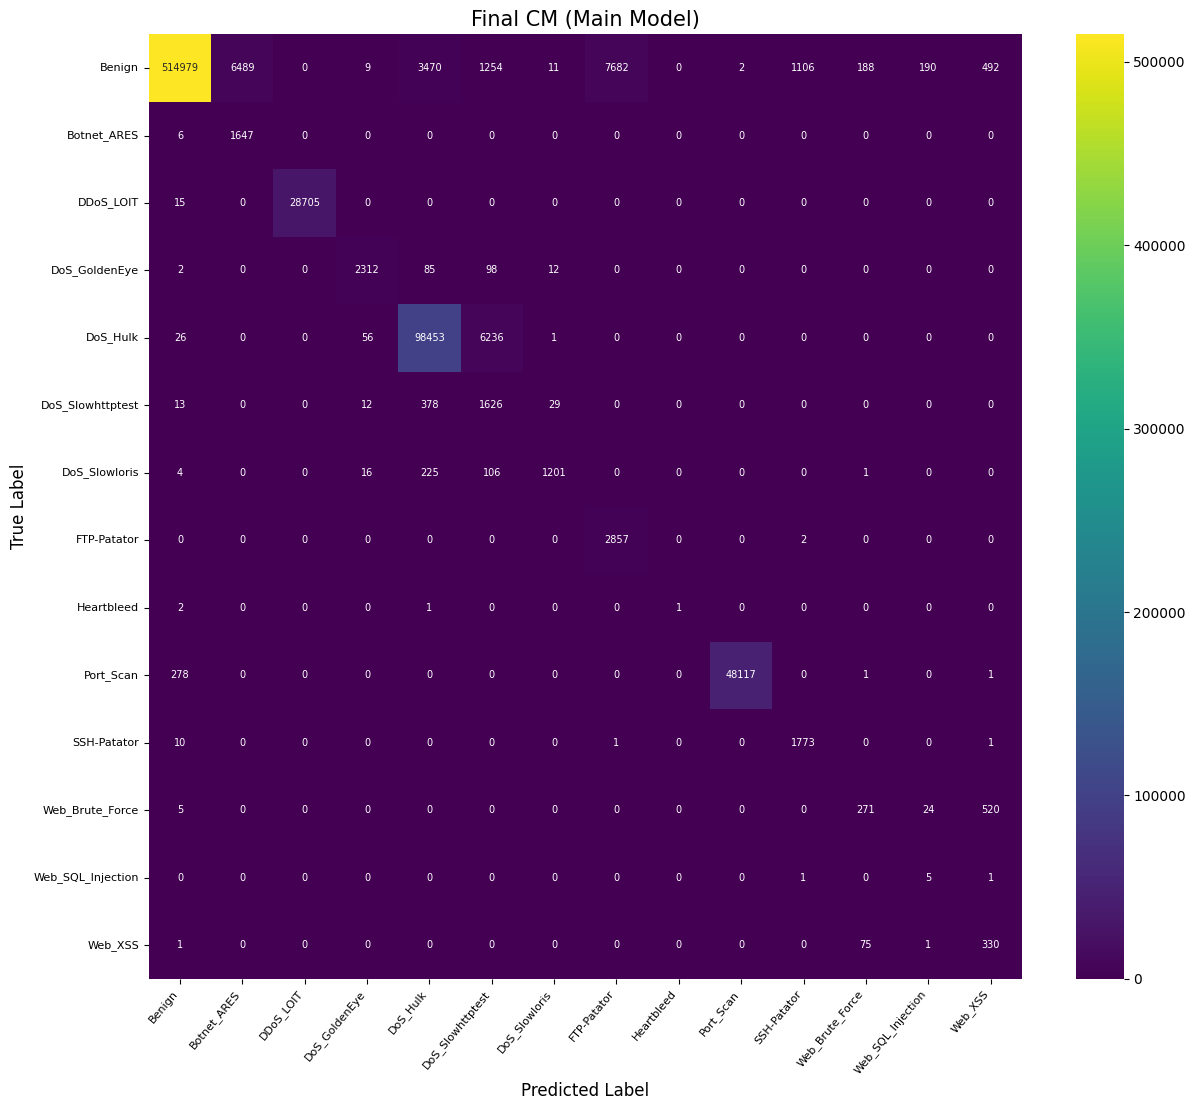

Plot saved: /kaggle/working/main_rf_model_feat_imp.png


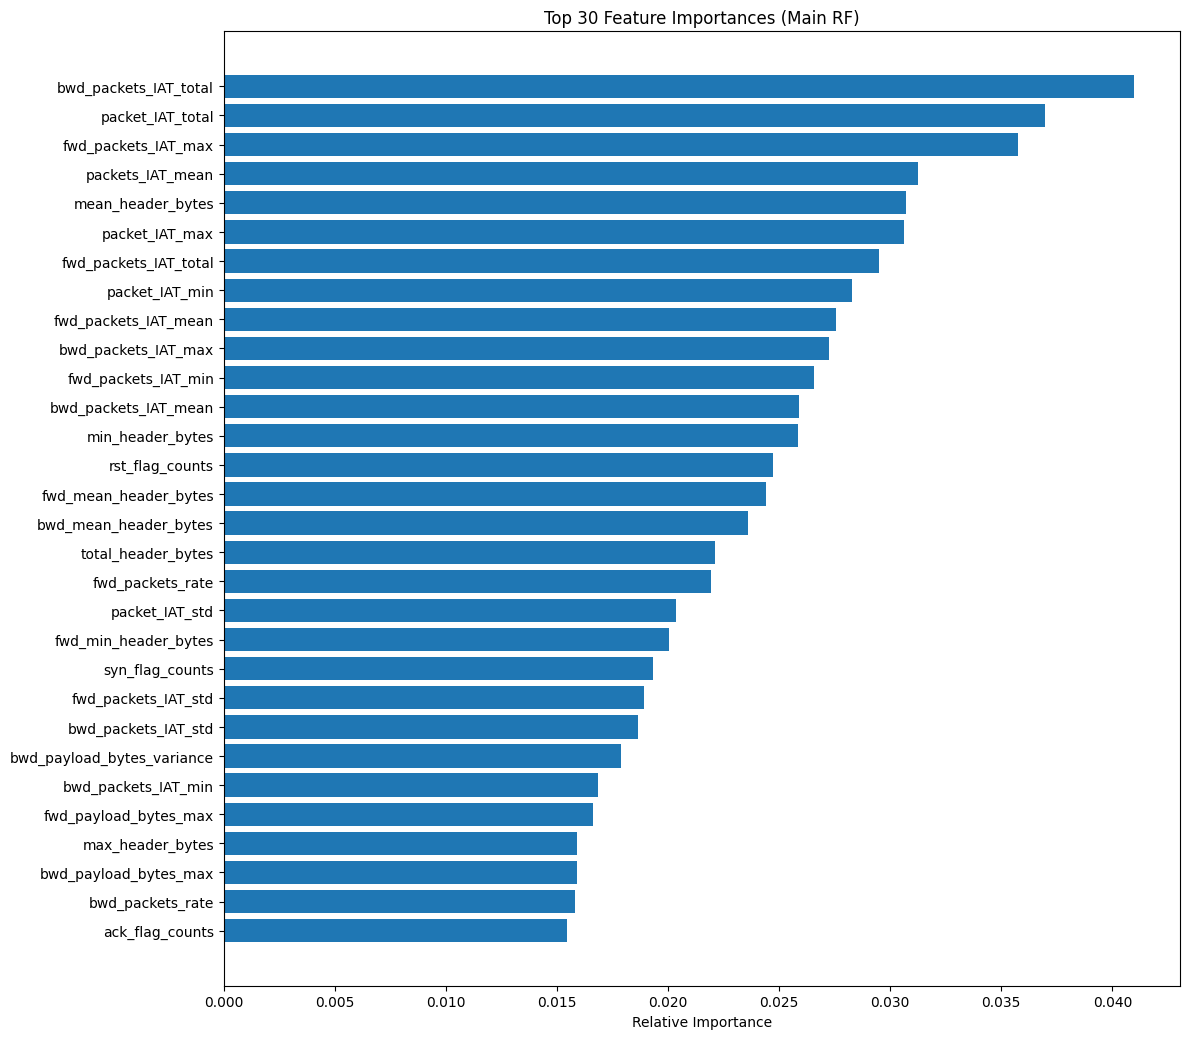


--- Web Attack Detector Evaluation ---
Web Detector Acc: 0.9994
              precision    recall  f1-score   support

     Not Web      1.000     1.000     1.000    730182
         Web      0.775     0.943     0.851      1234

    accuracy                          0.999    731416
   macro avg      0.887     0.971     0.925    731416
weighted avg      1.000     0.999     0.999    731416

Plot saved: /kaggle/working/web_detector_cm.png


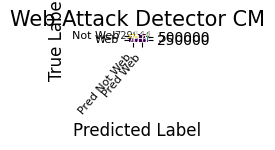

Checkpoint Main 11: Eval complete. Acc=0.9602


In [13]:
# <CELL>
# Cell: Model Evaluation
# Depends on components from the training cell

if main_rf_model_final: # Proceed only if model training was successful
    print("\nCheckpoint Main 10: Starting model evaluation (NF Focus).")
    try:
        final_preds_nf, eval_metrics_nf = evaluate_model_nf(
            main_rf_model_final, web_detector_model_final,
            X_test_final_scaled_selected_nf, y_test_mc_nf,
            is_web_test_bin_nf_series, # Pass Series for web test actuals
            main_label_encoder_final,
            main_model_selected_feature_names=final_selected_feature_names_for_main_model,
            save_plots_flag=True, output_dir=OUTPUT_PATH
        )
        print(f"Checkpoint Main 11: Eval complete. Acc={eval_metrics_nf.get('accuracy', -1):.4f}")
    except Exception as e_eval:
        print(f"Error during model evaluation: {e_eval}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping model evaluation as main_rf_model_final is None.")

In [14]:
# <CELL>
# Cell: Saving Artifacts
# Depends on components from training and evaluation

if main_rf_model_final and main_model_scaler_final and main_label_encoder_final and final_selected_feature_names_for_main_model:
    print("\nSaving final model artifacts (NF Focus)...")
    try:
        os.makedirs(OUTPUT_PATH, exist_ok=True)
        model_base_tag = "rf_nfstream_ctgan" if USE_CTGAN_FOR_WEB_AUGMENTATION and ctgan_available and CTGAN is not None else "rf_nfstream_smote_or_none"
        fs_tag_str = f"_FS{str(PERFORM_FEATURE_SELECTION)}" # True/False based on config
        final_save_tag = f"{model_base_tag}{fs_tag_str}_RS{RESAMPLING_METHOD_MAIN}"
        
        joblib.dump(main_rf_model_final, os.path.join(OUTPUT_PATH, f"main_detector_{final_save_tag}.joblib"))
        if web_detector_model_final: # Check if web detector was successfully created
            joblib.dump(web_detector_model_final, os.path.join(OUTPUT_PATH, f"web_detector_{final_save_tag}.joblib"))
        joblib.dump(main_model_scaler_final, os.path.join(OUTPUT_PATH, f"main_model_scaler_{final_save_tag}.joblib"))
        joblib.dump(main_label_encoder_final, os.path.join(OUTPUT_PATH, f"label_encoder_{final_save_tag}.joblib"))
        joblib.dump(final_selected_feature_names_for_main_model, os.path.join(OUTPUT_PATH, f"selected_features_main_model_{final_save_tag}.joblib"))
        print(f"Artifacts saved with tag: {final_save_tag}")
    except Exception as e_save:
        print(f"Error saving artifacts: {e_save}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping artifact saving as one or more key components are missing.")


Saving final model artifacts (NF Focus)...
Artifacts saved with tag: rf_nfstream_ctgan_FSTrue_RSSMOTE_RUS



--- Confidence Tiering & SHAP Explainability Demo (RF with NFStream features) ---
SHAP TreeExplainer for main RF model created.
Demonstrating confidence tiering on 5 test samples...

--- Confidence Analysis (Sample) ---
Top Pred: Benign (P=1.0000)
Tier: High
  Generating SHAP explanations...


<Figure size 640x480 with 0 Axes>

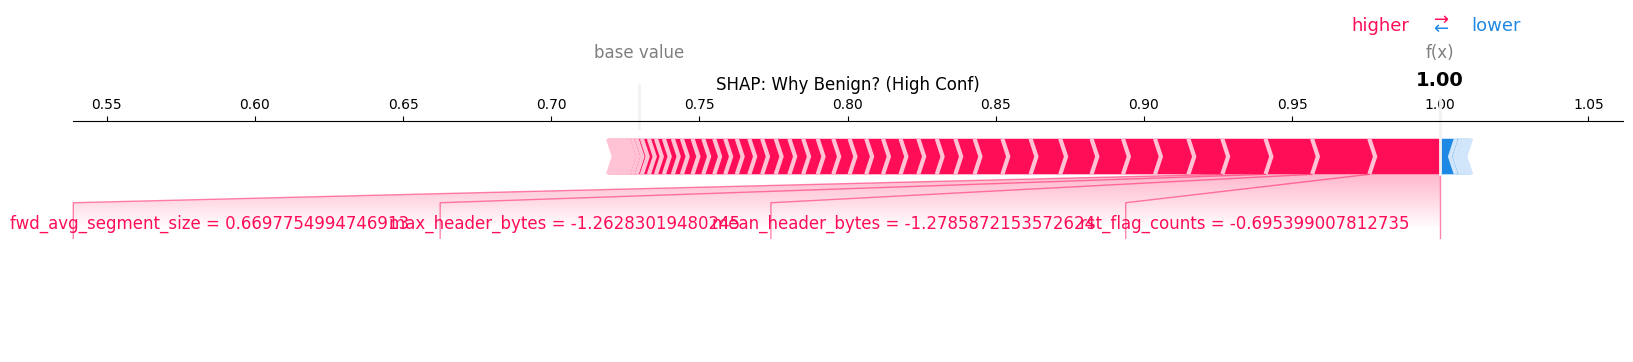

--- End Sample Analysis ---

--- Confidence Analysis (Sample) ---
Top Pred: Benign (P=0.9943)
Tier: High
  Generating SHAP explanations...


<Figure size 640x480 with 0 Axes>

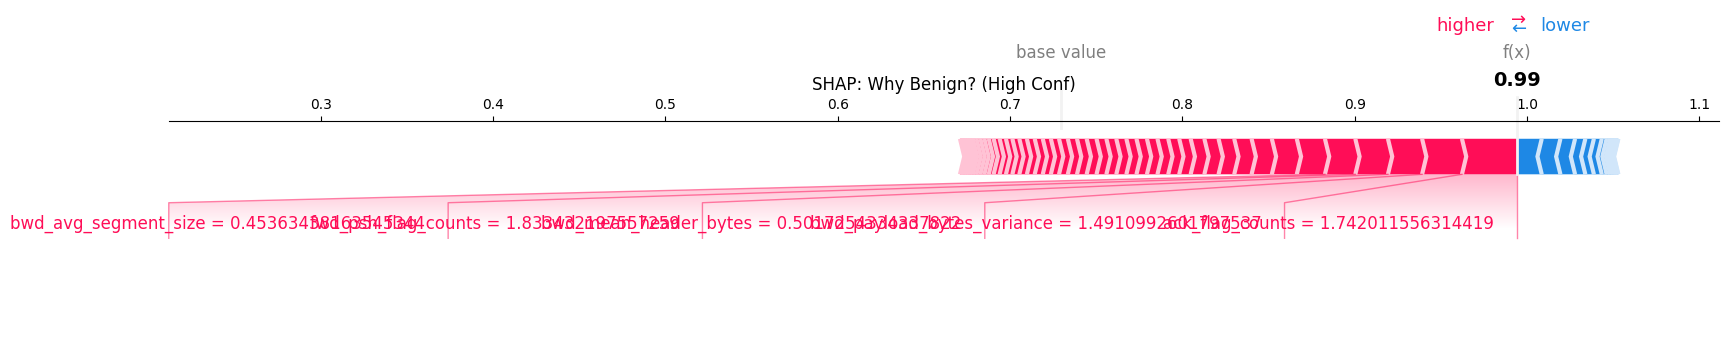

--- End Sample Analysis ---

--- Confidence Analysis (Sample) ---
Top Pred: Benign (P=1.0000)
Tier: High
  Generating SHAP explanations...


<Figure size 640x480 with 0 Axes>

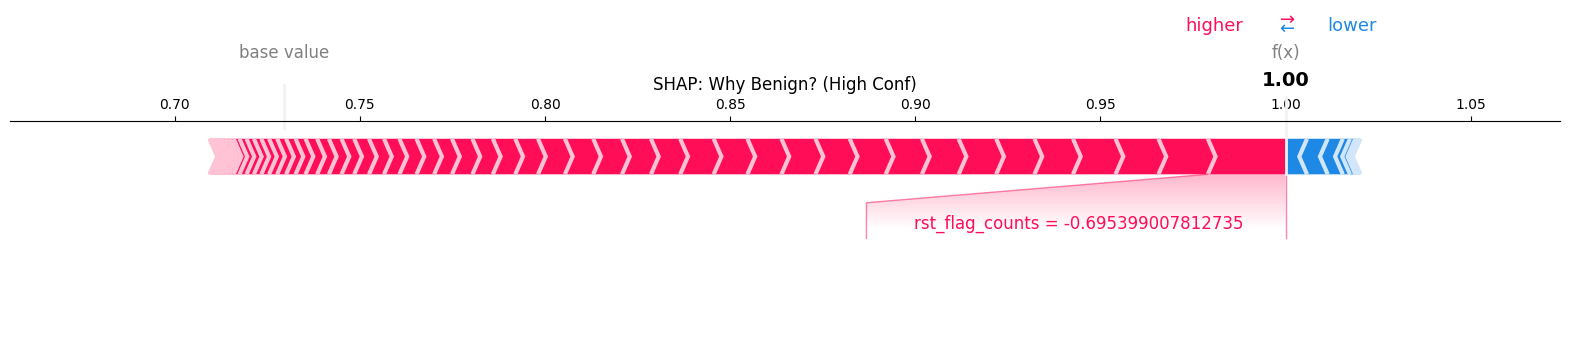

--- End Sample Analysis ---

--- Confidence Analysis (Sample) ---
Top Pred: Benign (P=0.8878)
Tier: Medium_Single
  Generating SHAP explanations...


<Figure size 640x480 with 0 Axes>

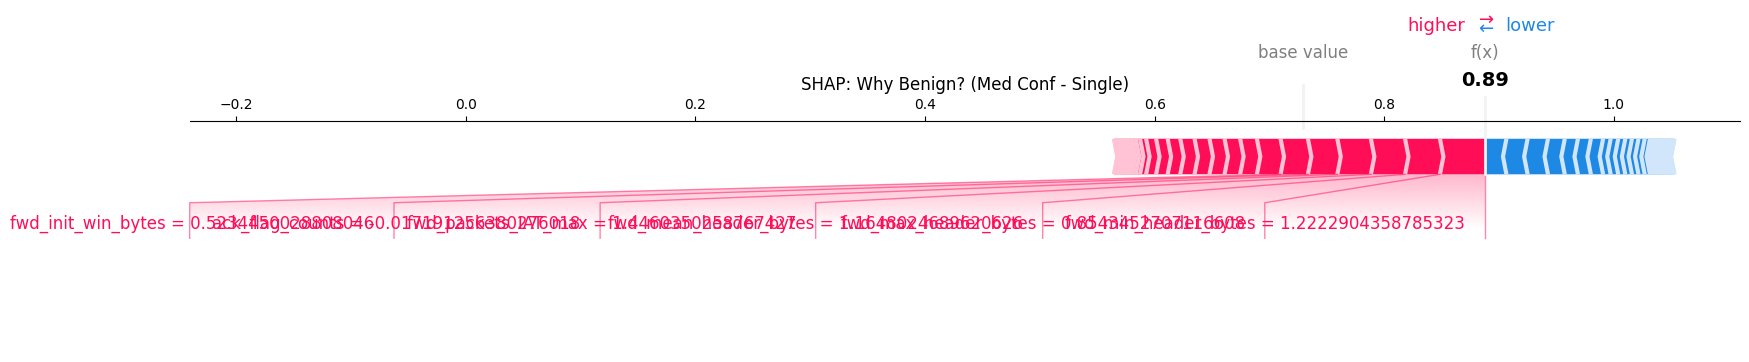

--- End Sample Analysis ---

--- Confidence Analysis (Sample) ---
Top Pred: Benign (P=1.0000)
Tier: High
  Generating SHAP explanations...


<Figure size 640x480 with 0 Axes>

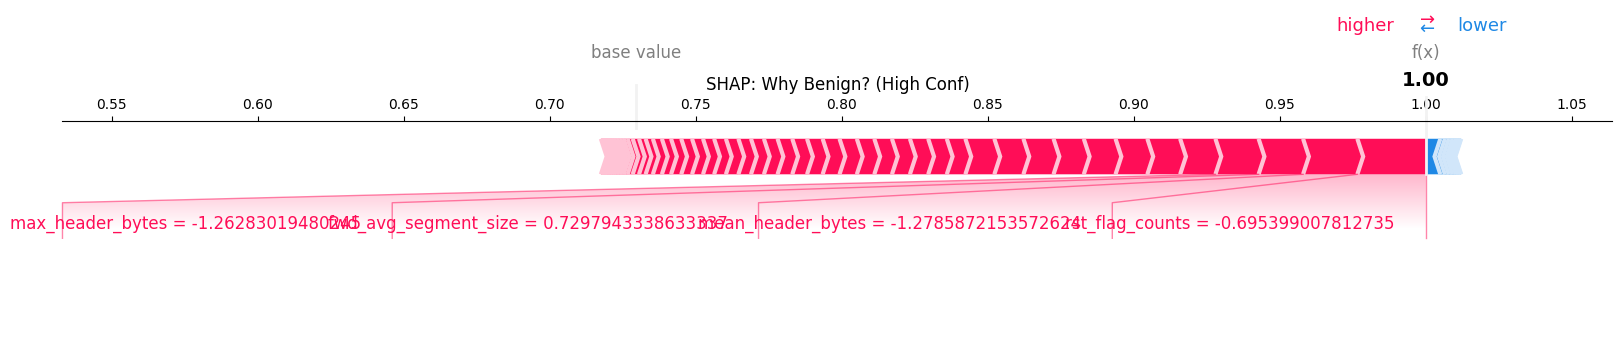

--- End Sample Analysis ---
Checkpoint Main 12: Script finished successfully (or with non-critical errors).


In [15]:
# <CELL>
# Cell: Confidence Tiering and SHAP Explainability Demo
# Depends on trained models and scalers

if shap_available and shap and main_rf_model_final and main_model_scaler_final and main_label_encoder_final and final_selected_feature_names_for_main_model:
    print("\n--- Confidence Tiering & SHAP Explainability Demo (RF with NFStream features) ---")
    try:
        # 1. Prepare SHAP Background Data
        # Use X_train_sel_nf_df (unscaled, but already feature-selected for the main model)
        # Scale it using main_model_scaler_final (which was fit on X_train_sel_nf_df)
        X_train_bg_unscaled_sel_feats_df = X_train_sel_nf_df.copy().replace([np.inf,-np.inf],np.nan).fillna(0.0)
        X_train_bg_scaled_for_shap = main_model_scaler_final.transform(X_train_bg_unscaled_sel_feats_df)
        
        # Ensure X_train_bg_df_for_shap has the correct column names (final_selected_feature_names_for_main_model)
        X_train_bg_df_for_shap = pd.DataFrame(X_train_bg_scaled_for_shap, columns=final_selected_feature_names_for_main_model, index=X_train_sel_nf_df.index)
        
        background_shap_sample = shap.sample(X_train_bg_df_for_shap, min(100, X_train_bg_df_for_shap.shape[0]), random_state=RANDOM_STATE) # Add random_state for consistency
        shap_explainer_rf_main = shap.TreeExplainer(main_rf_model_final, data=background_shap_sample)
        print("SHAP TreeExplainer for main RF model created.")

        # 2. Define Confidence Thresholds
        HIGH_T_RF = 0.90
        MED_T1_RF = 0.55
        MED_T2_RATIO_RF = 0.40
        LOW_MAX_P_RF = 0.45

        # 3. Demonstrate on a few samples from the test set
        # X_test_final_scaled_selected_nf is already scaled and has the correct selected features
        num_to_explain = min(5, X_test_final_scaled_selected_nf.shape[0])
        if num_to_explain > 0:
            print(f"Demonstrating confidence tiering on {num_to_explain} test samples...")
            
            # Get original indices from X_test_sel_nf_df to ensure consistency if X_test_final_scaled_selected_nf was created from it
            # This assumes X_test_final_scaled_selected_nf maintains row order corresponding to X_test_sel_nf_df
            indices_to_explain = X_test_sel_nf_df.sample(n=num_to_explain, random_state=RANDOM_STATE).index
            
            for i, original_idx in enumerate(indices_to_explain):
                # Find the corresponding row in X_test_final_scaled_selected_nf
                # This is tricky if indices were reset. A safer way is to sample from X_test_sel_nf_df (unscaled)
                # then scale just those samples for explanation.
                # Or, if X_test_final_scaled_selected_nf has an index aligned with X_test_sel_nf_df:
                
                # Let's assume X_test_final_scaled_selected_nf is a numpy array and its rows correspond
                # to the rows of X_test_sel_nf_df before scaling.
                # We need to find the row in X_test_final_scaled_selected_nf that corresponds to the i-th sampled original index.
                # This is simpler if we just iterate through the first few rows of the scaled test set.
                
                if i < X_test_final_scaled_selected_nf.shape[0]: # Ensure index is valid
                    sample_np_sh = X_test_final_scaled_selected_nf[i].reshape(1, -1) # Take first i-th row of scaled test set
                    sample_df_sh = pd.DataFrame(sample_np_sh, columns=final_selected_feature_names_for_main_model) # Names are correct
                    
                    analyze_sample_with_confidence_tiers_nf(
                        main_rf_model_shap=main_rf_model_final, shap_explainer_rf=shap_explainer_rf_main,
                        X_sample_scaled_selected_df=sample_df_sh, main_le_shap=main_label_encoder_final,
                        high_t=HIGH_T_RF, med_t1=MED_T1_RF, med_t2_ratio=MED_T2_RATIO_RF, low_max_p=LOW_MAX_P_RF,
                        output_plots_dir=os.path.join(OUTPUT_PATH, f"explain_rf_sample_{i}")
                    )
                else:
                    break # Break if we run out of samples in scaled test set
        else:
            print("No test samples available for SHAP demo (X_test_final_scaled_selected_nf is empty or too small).")
    except Exception as e_shap_demo:
        print(f"Error during SHAP explainability demo: {e_shap_demo}")
        import traceback
        traceback.print_exc()
elif not (shap_available and shap):
    print("\nSHAP library not available, skipping advanced explainability demo.")
else:
    print("\nSkipping SHAP explainability demo as one or more key components (model, scaler, encoder, features) are missing.")

print("Checkpoint Main 12: Script finished successfully (or with non-critical errors).")